In [1]:
!pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.6 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from aif360.datasets import BinaryLabelDataset  
from aif360.metrics import BinaryLabelDatasetMetric  
from aif360.algorithms.inprocessing import AdversarialDebiasing  
import tensorflow as tf  

import seaborn as sns
import matplotlib.pyplot as plt


2024-05-04 06:30:48.252858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 06:30:48.253000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 06:30:48.393413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def calculate_statistical_parity(df, sensitive_column, outcome_column):
    # Group by the sensitive column and calculate the mean of the outcome column
    group_means = df.groupby(sensitive_column)[outcome_column].mean()

    # Calculate the statistical parity
    stat_parity = group_means[1] - group_means[0]

    return stat_parity


In [4]:
def eq_oppo(preds, sens, labels):
    # Separate predictions and labels based on sensitive attribute
    preds_sensitive0 = preds[sens == 0]
    preds_sensitive1 = preds[sens == 1]
    labels_sensitive0 = labels[sens == 0]
    labels_sensitive1 = labels[sens == 1]
    
    # Calculate true positive rates for each sensitive group
    tpr_sensitive0 = np.mean(preds_sensitive0[labels_sensitive0 == 1])
    tpr_sensitive1 = np.mean(preds_sensitive1[labels_sensitive1 == 1])
    
    # Calculate equality of opportunity as the difference in true positive rates between sensitive groups
    equality_of_opportunity = tpr_sensitive0 - tpr_sensitive1
    
    return equality_of_opportunity


### Reading Data

In [5]:
df_job = pd.read_csv('/kaggle/input/70k-job-applicants-data-human-resource/stackoverflow_full.csv')
df_job = df_job[~df_job['Gender'].str.contains('NonBinary')]
df_promo_train = pd.read_csv('/kaggle/input/hr-ana/train.csv')


## Job Data

In [6]:
df_job['Gender']=df_job['Gender'].replace('Man',0)
df_job['Gender']=df_job['Gender'].replace('Woman',1)
df_job['Age']=df_job['Age'].replace('<35',0)
df_job['Age']=df_job['Age'].replace('>35',1)
df_job['MainBranch']=df_job['MainBranch'].replace('NotDev',0)
df_job['MainBranch']=df_job['MainBranch'].replace('Dev',1)
df_job['MentalHealth']=df_job['MentalHealth'].replace('Yes',0)
df_job['MentalHealth']=df_job['MentalHealth'].replace('No',1)

/tmp/ipykernel_34/3634169845.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_job['Gender']=df_job['Gender'].replace('Woman',1)
/tmp/ipykernel_34/3634169845.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_job['Age']=df_job['Age'].replace('>35',1)
/tmp/ipykernel_34/3634169845.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('fut

In [7]:
df_job.drop(['Country','HaveWorkedWith','Accessibility','Unnamed: 0'],axis=1,inplace=True)

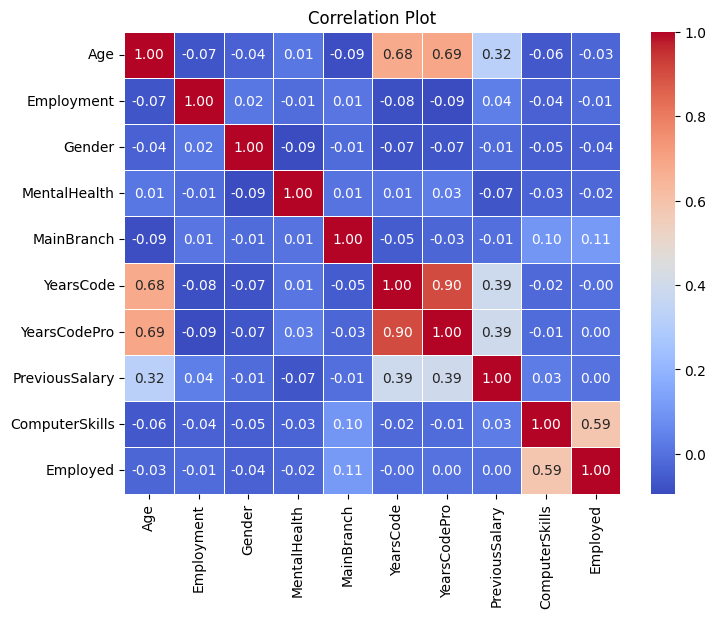

In [8]:
df = df_job.drop(['EdLevel'],axis=1)
# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Plot')
plt.show()


In [9]:
X = df_job.drop('Employed', axis=1)  # Features excluding the target column
y = df_job['Employed']  # Target variable

# Split the data into training and testing sets (adjust test_size as needed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
categ_cols = ['EdLevel']
num_cols = df_train_x.columns.difference(categ_cols)

# Create transformers for numerical and categorical columns
num_transformer = MinMaxScaler()
categ_transformer = OneHotEncoder(drop='first', sparse=False)

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', categ_transformer, categ_cols)
    ]
)

# Create a pipeline for pre-processing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the training data
train_x = pipeline.fit_transform(df_train_x)

# Transform the test data using the same transformer
test_x = pipeline.transform(df_test_x)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
clf = HistGradientBoostingClassifier().fit(train_x, df_train_y)
pred_y=clf.predict(test_x)
print("Accuracy:",clf.score(test_x,df_test_y))

Accuracy: 0.7895831888480477


In [12]:
stat_parity_result = calculate_statistical_parity(df_test_x.assign(Employed=pred_y), 'Gender', 'Employed')
print("Statistical Parity Gender:", stat_parity_result)
stat_parity_result = calculate_statistical_parity(df_test_x.assign(Employed=pred_y), 'Age', 'Employed')
print("Statistical Parity Age:", stat_parity_result)
equality_of_opportunity_result = eq_oppo(preds=pred_y, sens=df_test_x['Gender'].values, labels=df_test_y.values)
print("Equality of Opportunity Gender:", equality_of_opportunity_result)
equality_of_opportunity_result = eq_oppo(preds=pred_y, sens=df_test_x['Age'].values, labels=df_test_y.values)
print("Equality of Opportunity Age:", equality_of_opportunity_result)

Statistical Parity Gender: -0.12225452797021391
Statistical Parity Age: -0.02420535628462306
Equality of Opportunity Gender: 0.04632399282889599
Equality of Opportunity Age: -0.010518727788428106


## Promotion Data

In [13]:
df_promo_train = df_promo_train.drop(labels=['employee_id','region'],axis=1)
df_promo_train['gender']=df_promo_train['gender'].replace('m',0)
df_promo_train['gender']=df_promo_train['gender'].replace('f',1)
df_promo_train['age'] = df_promo_train['age'].apply(lambda x: 1 if x>35 else 0)

/tmp/ipykernel_34/1562266772.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_promo_train['gender']=df_promo_train['gender'].replace('f',1)


In [14]:
df_promo_train.head()

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,Master's & above,1,sourcing,1,0,5.0,8,0,49,0
1,Operations,Bachelor's,0,other,1,0,5.0,4,0,60,0
2,Sales & Marketing,Bachelor's,0,sourcing,1,0,3.0,7,0,50,0
3,Sales & Marketing,Bachelor's,0,other,2,1,1.0,10,0,50,0
4,Technology,Bachelor's,0,other,1,1,3.0,2,0,73,0


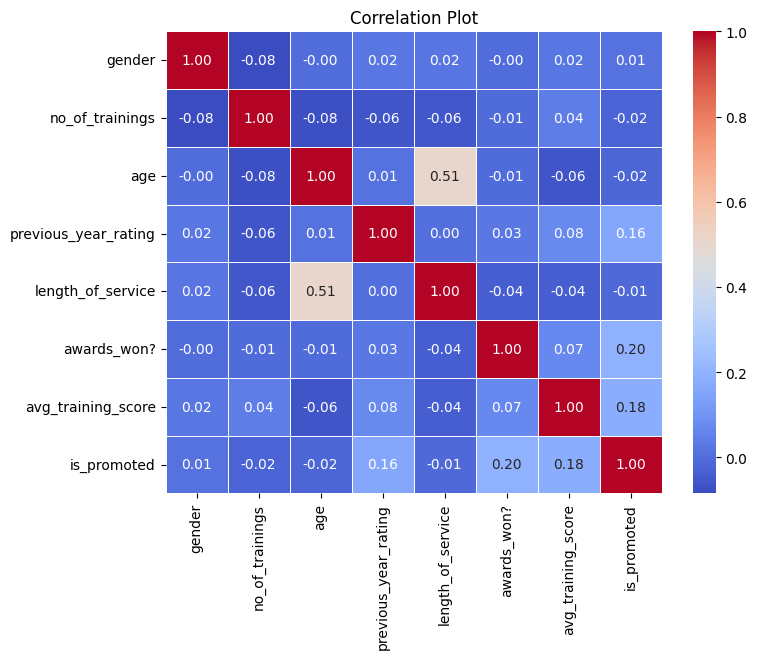

In [15]:
df = df_promo_train.drop(['education','recruitment_channel', 'department'],axis=1)
# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Plot')
plt.show()


In [16]:
X = df_promo_train.drop('is_promoted', axis=1)  # Features excluding the target column
y = df_promo_train['is_promoted']  # Target variable

# Split the data into training and testing sets (adjust test_size as needed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(X, y, test_size=0.2, random_state=42)

categ_cols = ['education','recruitment_channel', 'department']
num_cols = df_train_x.columns.difference(categ_cols)

# Create transformers for numerical and categorical columns
num_transformer = MinMaxScaler()
categ_transformer = OneHotEncoder(drop='first', sparse=False)

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', categ_transformer, categ_cols)
    ]
)

# Create a pipeline for pre-processing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the training data
train_x = pipeline.fit_transform(df_train_x)

# Transform the test data using the same transformer
test_x = pipeline.transform(df_test_x)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
clf = HistGradientBoostingClassifier().fit(train_x, df_train_y)
pred_y=clf.predict(test_x)
print("Accuracy:",clf.score(test_x,df_test_y))

Accuracy: 0.942893632548805


In [18]:
stat_parity_result = calculate_statistical_parity(df_test_x.assign(is_promoted=pred_y), 'gender', 'is_promoted')

print("Statistical Parity Gender:", stat_parity_result)
stat_parity_result = calculate_statistical_parity(df_test_x.assign(is_promoted=pred_y), 'age', 'is_promoted')

print("Statistical Parity Age:", stat_parity_result)
equality_of_opportunity_result = eq_oppo(preds=pred_y, sens=df_test_x['gender'].values, labels=df_test_y.values)
print("Equality of Opportunity Gender:", equality_of_opportunity_result)
equality_of_opportunity_result = eq_oppo(preds=pred_y, sens=df_test_x['age'].values, labels=df_test_y.values)
print("Equality of Opportunity Age:", equality_of_opportunity_result)

Statistical Parity Gender: -0.0015672608165752597
Statistical Parity Age: -0.0015306647348959264
Equality of Opportunity Gender: 0.04283154121863797
Equality of Opportunity Age: -0.05432448610859403


## Synthetic Data Generation

### Job Data

In [19]:
# Define parameters for generating synthetic data
num_samples = 10000 
prob_employed = 0.4
prob_young_age = 0.6
prob_female = 0.6

# Generate synthetic data for sensitive columns
age = np.random.choice([0, 1], size=num_samples, p=[prob_young_age, 1-prob_young_age])  # 0 for <35 and 1 for >35
gender = np.random.choice([0, 1], size=num_samples, p=[1-prob_female, prob_female])

# Introduce biases to decrease fairness
# Let's say younger individuals (age < 35) and females (gender = 1) are more likely to be employed
bias_employed = ((age == 0) & (np.random.rand(num_samples) < prob_young_age)) | (gender == 1)

# Generate synthetic data for other columns
ed_level = np.random.choice(['Undergraduate', 'Master', 'Other', 'NoHigherEd', 'PhD'], size=num_samples)
employment = np.random.randint(0, 2, size=num_samples)  # 1 for current job, 0 for no job
mental_health = np.random.randint(0, 2, size=num_samples)  # 1 for good, 0 for bad
main_branch = np.random.randint(0, 2, size=num_samples)  # 1 for Dev, 0 for NotDev
years_code = np.random.uniform(0, 1, size=num_samples)
years_code_pro = np.random.uniform(0, 1, size=num_samples)
previous_salary = np.random.uniform(0, 1, size=num_samples)
computer_skills = np.random.uniform(0, 1, size=num_samples)

# Generate synthetic data for the target variable with biases
employed = np.random.rand(num_samples) < prob_employed
employed[bias_employed] = True

# Create DataFrame
data = pd.DataFrame({
    'Age': age,
    'Gender': gender,
    'EdLevel': ed_level,
    'Employment': employment,
    'MentalHealth': mental_health,
    'MainBranch': main_branch,
    'YearsCode': years_code,
    'YearsCodePro': years_code_pro,
    'PreviousSalary': previous_salary,
    'ComputerSkills': computer_skills,
    'Employed': employed.astype(int)  # Convert boolean to integer
})
data['Gender']=data['Gender'].replace('Man',0)
data['Gender']=data['Gender'].replace('Woman',1)
data['Age']=data['Age'].replace('<35',0)
data['Age']=data['Age'].replace('>35',1)
data['MainBranch']=data['MainBranch'].replace('NotDev',0)
data['MainBranch']=data['MainBranch'].replace('Dev',1)
data['MentalHealth']=data['MentalHealth'].replace('Yes',0)
data['MentalHealth']=data['MentalHealth'].replace('No',1)
synth_data_job = data.reset_index(drop=True)
# Display the synthetic data
data.head()

,Age,Gender,EdLevel,Employment,MentalHealth,MainBranch,YearsCode,YearsCodePro,PreviousSalary,ComputerSkills,Employed
0,0,1,Undergraduate,0,1,1,0.505360,0.168639,0.255091,0.199224,1
1,1,1,Master,0,1,1,0.155732,0.537976,0.410598,0.617045,1
2,1,1,PhD,1,0,1,0.757103,0.153111,0.303971,0.807842,1
3,0,1,Other,1,1,1,0.191970,0.255277,0.828279,0.655583,1
4,0,1,Other,0,1,0,0.000271,0.332811,0.096883,0.868167,1


In [20]:
synth_data_job[(synth_data_job['Gender']==1) & (synth_data_job['Employed']==1)]

,Age,Gender,EdLevel,Employment,MentalHealth,MainBranch,YearsCode,YearsCodePro,PreviousSalary,ComputerSkills,Employed
0,0,1,Undergraduate,0,1,1,0.505360,0.168639,0.255091,0.199224,1
1,1,1,Master,0,1,1,0.155732,0.537976,0.410598,0.617045,1
2,1,1,PhD,1,0,1,0.757103,0.153111,0.303971,0.807842,1
3,0,1,Other,1,1,1,0.191970,0.255277,0.828279,0.655583,1
4,0,1,Other,0,1,0,0.000271,0.332811,0.096883,0.868167,1
...,...,...,...,...,...,...,...,...,...,...,...
9988,1,1,PhD,0,0,1,0.912559,0.106130,0.598252,0.782450,1
9989,1,1,NoHigherEd,0,0,0,0.402683,0.139886,0.601397,0.500457,1
9990,0,1,Undergraduate,0,0,0,0.688566,0.140217,0.389407,0.314279,1
9992,0,1,PhD,1,0,1,0.705063,0.782103,0.711636,0.314089,1


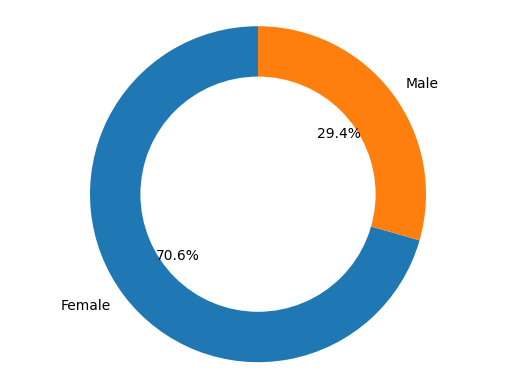

In [21]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Female', 'Male']
sizes = [5955,2483]
# explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Draw a circle at the center
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()


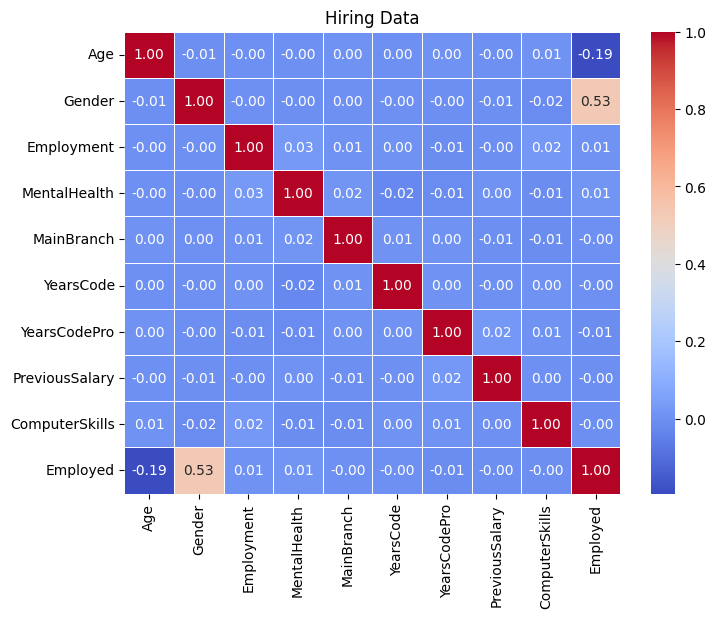

In [22]:
df = synth_data_job.drop(['EdLevel'],axis=1)
# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Hiring Data')
plt.show()


In [23]:
X = synth_data_job.drop('Employed', axis=1)  # Features excluding the target column
y = synth_data_job['Employed']  # Target variable

# Split the data into training and testing sets (adjust test_size as needed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(X, y, test_size=0.2, random_state=42)

categ_cols = ['EdLevel']
num_cols = df_train_x.columns.difference(categ_cols)

# Create transformers for numerical and categorical columns
num_transformer = MinMaxScaler()
categ_transformer = OneHotEncoder(drop='first', sparse=False)

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', categ_transformer, categ_cols)
    ]
)

# Create a pipeline for pre-processing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the training data
train_x = pipeline.fit_transform(df_train_x)

# Transform the test data using the same transformer
test_x = pipeline.transform(df_test_x)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [24]:
clf = HistGradientBoostingClassifier(random_state=0).fit(train_x, df_train_y)
pred_y = clf.predict(test_x)
print("Accuracy:",clf.score(test_x,df_test_y))

Accuracy: 0.8645


In [25]:
stat_parity_result = calculate_statistical_parity(df_test_x.assign(Employed=pred_y), 'Gender', 'Employed')

print("Statistical Parity Gender:", stat_parity_result)
stat_parity_result = calculate_statistical_parity(df_test_x.assign(Employed=pred_y), 'Age', 'Employed')

print("Statistical Parity Age:", stat_parity_result)
equality_of_opportunity_result = eq_oppo(preds=pred_y, sens=df_test_x['Gender'].values, labels=df_test_y.values)
print("Equality of Opportunity Gender:", equality_of_opportunity_result)
equality_of_opportunity_result = eq_oppo(preds=pred_y, sens=df_test_x['Age'].values, labels=df_test_y.values)
print("Equality of Opportunity Age:", equality_of_opportunity_result)

Statistical Parity Gender: 0.34303797468354436
Statistical Parity Age: -0.2798637274800563
Equality of Opportunity Gender: -0.24485596707818935
Equality of Opportunity Age: 0.14044950634354603


### Promotion Data

In [26]:
# Define parameters for generating synthetic data
num_samples = 10000 
prob_promoted = 0.4 
prob_male = 0.6    
prob_older_age = 0.6  

# Generate synthetic data for sensitive columns
gender = np.random.choice(['m', 'f'], size=num_samples, p=[1-prob_male, prob_male])
age = np.random.randint(20, 60, size=num_samples)

# Introduce biases to decrease fairness
# Let's say younger employees (age < 30) and females (gender = 'f') are more likely to be promoted
# bias_promoted = (age < 30) & (gender == 'f')

bias_promoted = ((age > 35) & (np.random.rand(num_samples) < prob_older_age)) | (gender == 'm')

# Generate synthetic data for other columns
no_of_trainings = np.random.randint(1, 10, size=num_samples)
previous_year_rating = np.random.randint(1, 6, size=num_samples)
length_of_service = np.random.randint(1, 37, size=num_samples)
awards_won = np.random.randint(0, 2, size=num_samples)
avg_training_score = np.random.randint(40, 100, size=num_samples)
education = np.random.choice(["Bachelor's", "Master's & above", "Below Secondary"], size=num_samples)
recruitment_channel = np.random.choice(['other', 'sourcing', 'referred'], size=num_samples)
department = np.random.choice(['Sales & Marketing', 'Technology', 'R&D', 'Operations', 'Finance',
                               'Procurement', 'Analytics', 'HR', 'Legal'], size=num_samples)

# Generate synthetic data for the target variable with biases
is_promoted = np.random.rand(num_samples) < prob_promoted
is_promoted[bias_promoted] = True

# Create DataFrame
data = pd.DataFrame({
    'gender': gender,
    'age': age,
    'no_of_trainings': no_of_trainings,
    'previous_year_rating': previous_year_rating,
    'length_of_service': length_of_service,
    'awards_won': awards_won,
    'avg_training_score': avg_training_score,
    'education': education,
    'recruitment_channel': recruitment_channel,
    'department': department,
    'is_promoted': is_promoted.astype(int)  # Convert boolean to integer
})
data['age'] = data['age'].apply(lambda x: 1 if x>35 else 0)
data['gender']=data['gender'].replace('m',0)
data['gender']=data['gender'].replace('f',1)
synth_data_prom = data.reset_index(drop=True)
# Save synthetic data to a CSV file
# data.to_csv('synthetic_data.csv', index=False)

# Display the synthetic data
synth_data_prom.head()

/tmp/ipykernel_34/954885167.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['gender']=data['gender'].replace('f',1)


,gender,age,no_of_trainings,previous_year_rating,length_of_service,awards_won,avg_training_score,education,recruitment_channel,department,is_promoted
0,0,1,8,5,13,0,43,Below Secondary,sourcing,Legal,1
1,0,1,8,5,24,0,55,Master's & above,sourcing,Sales & Marketing,1
2,1,0,8,1,36,0,76,Bachelor's,referred,Sales & Marketing,0
3,1,1,7,4,18,1,79,Below Secondary,referred,Sales & Marketing,0
4,0,1,9,5,30,0,88,Bachelor's,sourcing,Operations,1


In [27]:
synth_data_prom[(synth_data_prom['age']==1) & (synth_data_prom['is_promoted']==1)]

,gender,age,no_of_trainings,previous_year_rating,length_of_service,awards_won,avg_training_score,education,recruitment_channel,department,is_promoted
0,0,1,8,5,13,0,43,Below Secondary,sourcing,Legal,1
1,0,1,8,5,24,0,55,Master's & above,sourcing,Sales & Marketing,1
4,0,1,9,5,30,0,88,Bachelor's,sourcing,Operations,1
8,0,1,4,1,26,0,44,Master's & above,other,Finance,1
12,0,1,9,3,14,0,65,Bachelor's,sourcing,Analytics,1
...,...,...,...,...,...,...,...,...,...,...,...
9988,0,1,2,2,6,0,89,Below Secondary,other,Procurement,1
9989,0,1,4,2,23,0,92,Master's & above,other,Technology,1
9994,1,1,2,3,22,0,76,Below Secondary,other,HR,1
9996,1,1,9,4,19,0,71,Bachelor's,sourcing,Analytics,1


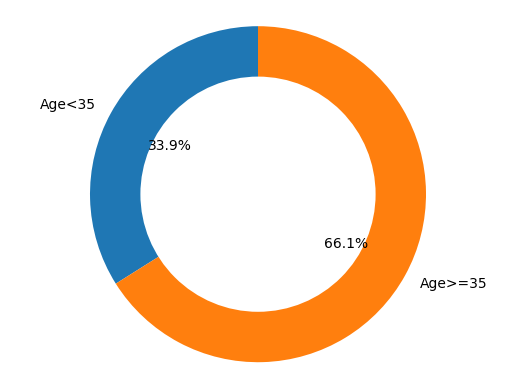

In [28]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Age<35', 'Age>=35']
sizes = [2616,5092]
# explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Draw a circle at the center
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()


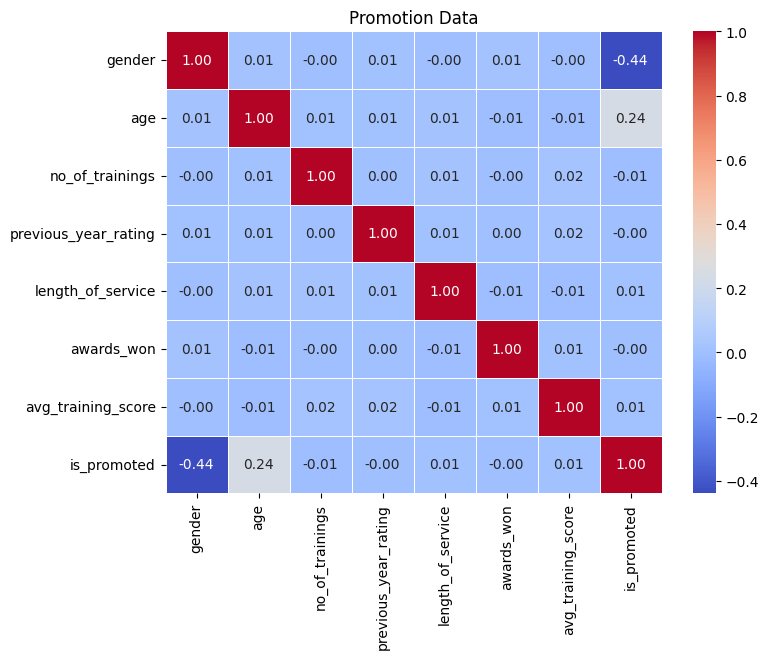

In [29]:
df = synth_data_prom.drop(['education','recruitment_channel', 'department'],axis=1)
# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Promotion Data')
plt.show()


In [30]:
X = synth_data_prom.drop('is_promoted', axis=1)  # Features excluding the target column
y = synth_data_prom['is_promoted']  # Target variable

# Split the data into training and testing sets (adjust test_size as needed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(X, y, test_size=0.2, random_state=42)

categ_cols = ['education','recruitment_channel', 'department']
num_cols = df_train_x.columns.difference(categ_cols)

# Create transformers for numerical and categorical columns
num_transformer = MinMaxScaler()
categ_transformer = OneHotEncoder(drop='first', sparse=False)

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', categ_transformer, categ_cols)
    ]
)

# Create a pipeline for pre-processing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the training data
train_x = pipeline.fit_transform(df_train_x)

# Transform the test data using the same transformer
test_x = pipeline.transform(df_test_x)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [31]:
clf = HistGradientBoostingClassifier().fit(train_x, df_train_y)
pred_y=clf.predict(test_x)
print("Accuracy:",clf.score(test_x,df_test_y))

Accuracy: 0.8015


In [32]:
stat_parity_result = calculate_statistical_parity(df_test_x.assign(is_promoted=pred_y), 'gender', 'is_promoted')

print("Statistical Parity Gender:", stat_parity_result)
stat_parity_result = calculate_statistical_parity(df_test_x.assign(is_promoted=pred_y), 'age', 'is_promoted')

print("Statistical Parity Age:", stat_parity_result)

equality_of_opportunity_result = eq_oppo(preds=pred_y, sens=df_test_x['gender'].values, labels=df_test_y.values)
print("Equality of Opportunity Gender:", equality_of_opportunity_result)

equality_of_opportunity_result = eq_oppo(preds=pred_y, sens=df_test_x['age'].values, labels=df_test_y.values)
print("Equality of Opportunity Age:", equality_of_opportunity_result)

Statistical Parity Gender: -0.3018092105263158
Statistical Parity Age: 0.4406369955389563
Equality of Opportunity Gender: 0.2064935064935065
Equality of Opportunity Age: -0.28679337231968804


## Bias Mitigation
#### By removing sensitive features

### Job Data

In [33]:
synth_data_job_no_sens = synth_data_job.drop(['Age','Gender'],axis=1)
X = synth_data_job_no_sens.drop('Employed', axis=1)  # Features excluding the target column
y = synth_data_job_no_sens['Employed']  # Target variable

# Split the data into training and testing sets (adjust test_size as needed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(X, y, test_size=0.2, random_state=42)

categ_cols = ['EdLevel']
num_cols = df_train_x.columns.difference(categ_cols)

# Create transformers for numerical and categorical columns
num_transformer = MinMaxScaler()
categ_transformer = OneHotEncoder(drop='first', sparse=False)

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', categ_transformer, categ_cols)
    ]
)

# Create a pipeline for pre-processing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the training data
train_x = pipeline.fit_transform(df_train_x)

# Transform the test data using the same transformer
test_x = pipeline.transform(df_test_x)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [34]:
clf = HistGradientBoostingClassifier().fit(train_x, df_train_y)
pred_y=clf.predict(test_x)
print("Accuracy:",clf.score(test_x,df_test_y))

Accuracy: 0.845


### Promotion Data

In [35]:
synth_data_prom_no_sens = synth_data_prom.drop(['age','gender'],axis=1)
X = synth_data_prom_no_sens.drop('is_promoted', axis=1)  # Features excluding the target column
y = synth_data_prom_no_sens['is_promoted']  # Target variable

# Split the data into training and testing sets (adjust test_size as needed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(X, y, test_size=0.2, random_state=42)

categ_cols = ['education','recruitment_channel', 'department']
num_cols = df_train_x.columns.difference(categ_cols)

# Create transformers for numerical and categorical columns
num_transformer = MinMaxScaler()
categ_transformer = OneHotEncoder(drop='first', sparse=False)

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', categ_transformer, categ_cols)
    ]
)

# Create a pipeline for pre-processing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the training data
train_x = pipeline.fit_transform(df_train_x)

# Transform the test data using the same transformer
test_x = pipeline.transform(df_test_x)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [36]:
clf = HistGradientBoostingClassifier().fit(train_x, df_train_y)
pred_y=clf.predict(test_x)
print("Accuracy:",clf.score(test_x,df_test_y))

Accuracy: 0.776


By Data Augmentation

In [37]:
synth_data_job_aug = synth_data_job.reset_index(drop=True)
synth_data_job_aug = synth_data_job_aug.assign(Age=np.where(synth_data_job['Age'] == 0, 1, 0))
synth_data_job_aug = synth_data_job_aug.assign(Gender=np.where(synth_data_job['Gender'] == 0, 1, 0))
synth_data_job_aug = pd.concat([synth_data_job,synth_data_job_aug])

X = synth_data_job_aug.drop('Employed', axis=1)  # Features excluding the target column
y = synth_data_job_aug['Employed']  # Target variable

# Split the data into training and testing sets (adjust test_size as needed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(X, y, test_size=0.2, random_state=42)

categ_cols = ['EdLevel']
num_cols = df_train_x.columns.difference(categ_cols)

# Create transformers for numerical and categorical columns
num_transformer = MinMaxScaler()
categ_transformer = OneHotEncoder(drop='first', sparse=False)

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', categ_transformer, categ_cols)
    ]
)

# Create a pipeline for pre-processing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the training data
train_x = pipeline.fit_transform(df_train_x)

# Transform the test data using the same transformer
test_x = pipeline.transform(df_test_x)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [38]:
clf = HistGradientBoostingClassifier().fit(train_x, df_train_y)
pred_y=clf.predict(test_x)
print("Accuracy:",clf.score(test_x,df_test_y))

Accuracy: 0.858


In [39]:
stat_parity_result = calculate_statistical_parity(df_test_x.assign(Employed=pred_y), 'Gender', 'Employed')

print("Statistical Parity Gender:", stat_parity_result)
stat_parity_result = calculate_statistical_parity(df_test_x.assign(Employed=pred_y), 'Age', 'Employed')

print("Statistical Parity Age:", stat_parity_result)
equality_of_opportunity_result = eq_oppo(preds=pred_y, sens=df_test_x['Gender'].values, labels=df_test_y.values)
print("Equality of Opportunity Gender:", equality_of_opportunity_result)
equality_of_opportunity_result = eq_oppo(preds=pred_y, sens=df_test_x['Age'].values, labels=df_test_y.values)
print("Equality of Opportunity Age:", equality_of_opportunity_result)

Statistical Parity Gender: 0.0003447955992179619
Statistical Parity Age: -0.0035405318647868667
Equality of Opportunity Gender: -0.0005556984821198929
Equality of Opportunity Age: 0.0005762253535039896


Promotion Data

In [40]:
synth_data_prom_aug = synth_data_prom.reset_index(drop=True)
synth_data_prom_aug = synth_data_prom_aug.assign(age=np.where(synth_data_prom_aug['age'] == 0, 1, 0))
synth_data_prom_aug = synth_data_prom_aug.assign(gender=np.where(synth_data_prom_aug['gender'] == 0, 1, 0))
synth_data_prom_aug = pd.concat([synth_data_prom,synth_data_prom_aug])

X = synth_data_prom_aug.drop('is_promoted', axis=1)  # Features excluding the target column
y = synth_data_prom_aug['is_promoted']  # Target variable

# Split the data into training and testing sets (adjust test_size as needed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(X, y, test_size=0.2, random_state=42)

categ_cols = ['education','recruitment_channel', 'department']
num_cols = df_train_x.columns.difference(categ_cols)

# Create transformers for numerical and categorical columns
num_transformer = MinMaxScaler()
categ_transformer = OneHotEncoder(drop='first', sparse=False)

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', categ_transformer, categ_cols)
    ]
)

# Create a pipeline for pre-processing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the training data
train_x = pipeline.fit_transform(df_train_x)

# Transform the test data using the same transformer
test_x = pipeline.transform(df_test_x)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [41]:
clf = HistGradientBoostingClassifier().fit(train_x, df_train_y)
pred_y=clf.predict(test_x)
print("Accuracy:",clf.score(test_x,df_test_y))

Accuracy: 0.77975


In [42]:
stat_parity_result = calculate_statistical_parity(df_test_x.assign(is_promoted=pred_y), 'gender', 'is_promoted')

print("Statistical Parity Gender:", stat_parity_result)
stat_parity_result = calculate_statistical_parity(df_test_x.assign(is_promoted=pred_y), 'age', 'is_promoted')

print("Statistical Parity Age:", stat_parity_result)

equality_of_opportunity_result = eq_oppo(preds=pred_y, sens=df_test_x['gender'].values, labels=df_test_y.values)
print("Equality of Opportunity Gender:", equality_of_opportunity_result)

equality_of_opportunity_result = eq_oppo(preds=pred_y, sens=df_test_x['age'].values, labels=df_test_y.values)
print("Equality of Opportunity Age:", equality_of_opportunity_result)

Statistical Parity Gender: -0.0033453596918038286
Statistical Parity Age: -0.0008631064173426628
Equality of Opportunity Gender: 0.0006298179514329094
Equality of Opportunity Age: -0.0005903484886620181


#### Adversarial Learning

#### Job Data

In [43]:
tf.compat.v1.disable_eager_execution()
# Assume you have a pandas DataFrame `df`, where `is_promoted` is the target column   
# and `age` and `gender` are the sensitive attributes  
  
privileged_groups = [{'Age': 0, 'Gender': 1}]   
unprivileged_groups = [{'Age': 1, 'Gender': 0}]  
df = synth_data_job.drop(['EdLevel','PreviousSalary'],axis=1)
# Create a BinaryLabelDataset from the DataFrame  
dataset = BinaryLabelDataset(df=df, label_names=['Employed'],   
                             protected_attribute_names=['Age', 'Gender'],   
                             favorable_label=1, unfavorable_label=0)  
  
# Compute the fairness metric before debiasing  
metric_orig = BinaryLabelDatasetMetric(dataset,   
                                       unprivileged_groups=unprivileged_groups,  
                                       privileged_groups=privileged_groups)  
print("Original fairness metric:", metric_orig.mean_difference())  
  
# Train the AdversarialDebiasing model  
sess = tf.compat.v1.Session()  
adv_debias = AdversarialDebiasing(privileged_groups=privileged_groups,  
                                  unprivileged_groups=unprivileged_groups,  
                                  scope_name='debiased_classifier_job', 
                                  debias=True,  
                                  sess=sess,
                                 num_epochs=50)  
  
adv_debias.fit(dataset)  
  
# Apply the model to the original dataset to obtain a new dataset  
dataset_debiased = adv_debias.predict(dataset)  
  
# Compute the fairness metric after debiasing  
metric_debiased = BinaryLabelDatasetMetric(dataset_debiased,   
                                           unprivileged_groups=unprivileged_groups,  
                                           privileged_groups=privileged_groups)  
print("Debiased fairness metric:", metric_debiased.mean_difference())  
  
# Close the TensorFlow session  
sess.close()  


Original fairness metric: -0.6066084788029925
epoch 0; iter: 0; batch classifier loss: 0.654336; batch adversarial loss: 0.777112
epoch 1; iter: 0; batch classifier loss: 0.355204; batch adversarial loss: 0.754075
epoch 2; iter: 0; batch classifier loss: 0.235528; batch adversarial loss: 0.750542
epoch 3; iter: 0; batch classifier loss: 0.293251; batch adversarial loss: 0.712791
epoch 4; iter: 0; batch classifier loss: 0.254942; batch adversarial loss: 0.719652
epoch 5; iter: 0; batch classifier loss: 0.288539; batch adversarial loss: 0.695971
epoch 6; iter: 0; batch classifier loss: 0.214762; batch adversarial loss: 0.666056
epoch 7; iter: 0; batch classifier loss: 0.266411; batch adversarial loss: 0.669127
epoch 8; iter: 0; batch classifier loss: 0.282681; batch adversarial loss: 0.711491
epoch 9; iter: 0; batch classifier loss: 0.262594; batch adversarial loss: 0.673258
epoch 10; iter: 0; batch classifier loss: 0.228377; batch adversarial loss: 0.689618
epoch 11; iter: 0; batch clas

In [44]:
df,_ = dataset.convert_to_dataframe()
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df.drop(['Employed'],axis=1), df['Employed'], test_size=0.2, random_state=42)
clf = HistGradientBoostingClassifier().fit(df_train_x.values, df_train_y.values)
# pred_y=clf.predict(test_x)
print("Accuracy:",clf.score(df_test_x.values,df_test_y))

Accuracy: 0.8695


#### Promotion Data

In [45]:

  
# Assume you have a pandas DataFrame `df`, where `is_promoted` is the target column   
# and `age` and `gender` are the sensitive attributes  
  
privileged_groups = [{'age': 1, 'gender': 0}]   
unprivileged_groups = [{'age': 0, 'gender': 1}]  
df = synth_data_prom.drop(['education','recruitment_channel', 'department'],axis=1)
# Create a BinaryLabelDataset from the DataFrame  
dataset = BinaryLabelDataset(df=df, label_names=['is_promoted'],   
                             protected_attribute_names=['age', 'gender'],   
                             favorable_label=1, unfavorable_label=0)  
  
# Compute the fairness metric before debiasing  
metric_orig = BinaryLabelDatasetMetric(dataset,   
                                       unprivileged_groups=unprivileged_groups,  
                                       privileged_groups=privileged_groups)  
print("Original fairness metric:", metric_orig.mean_difference())  
  
# Train the AdversarialDebiasing model  
sess = tf.compat.v1.Session()  
adv_debias = AdversarialDebiasing(privileged_groups=privileged_groups,  
                                  unprivileged_groups=unprivileged_groups,  
                                  scope_name='debiased_classifier_prom', 
                                  debias=True,  
                                  sess=sess)  
  
adv_debias.fit(dataset)  
  
# Apply the model to the original dataset to obtain a new dataset  
dataset_debiased = adv_debias.predict(dataset)  
  
# Compute the fairness metric after debiasing  
metric_debiased = BinaryLabelDatasetMetric(dataset_debiased,   
                                           unprivileged_groups=unprivileged_groups,  
                                           privileged_groups=privileged_groups)  
print("Debiased fairness metric:", metric_debiased.mean_difference())  
  
# Close the TensorFlow session  
sess.close()  


Original fairness metric: -0.5849852382960776
epoch 0; iter: 0; batch classifier loss: 3.821674; batch adversarial loss: 0.768940
epoch 1; iter: 0; batch classifier loss: 0.980557; batch adversarial loss: 0.695952
epoch 2; iter: 0; batch classifier loss: 0.684679; batch adversarial loss: 0.695898
epoch 3; iter: 0; batch classifier loss: 0.536628; batch adversarial loss: 0.658953
epoch 4; iter: 0; batch classifier loss: 0.471203; batch adversarial loss: 0.692659
epoch 5; iter: 0; batch classifier loss: 0.483724; batch adversarial loss: 0.700948
epoch 6; iter: 0; batch classifier loss: 0.496333; batch adversarial loss: 0.660366
epoch 7; iter: 0; batch classifier loss: 0.476066; batch adversarial loss: 0.677931
epoch 8; iter: 0; batch classifier loss: 0.385504; batch adversarial loss: 0.663301
epoch 9; iter: 0; batch classifier loss: 0.511431; batch adversarial loss: 0.631030
epoch 10; iter: 0; batch classifier loss: 0.300864; batch adversarial loss: 0.674293
epoch 11; iter: 0; batch clas

In [46]:
df,_ = dataset.convert_to_dataframe()
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df.drop(['is_promoted'],axis=1), df['is_promoted'], test_size=0.2, random_state=42)
clf = HistGradientBoostingClassifier().fit(df_train_x.values, df_train_y.values)
# pred_y=clf.predict(test_x)
print("Accuracy:",clf.score(df_test_x.values,df_test_y))

Accuracy: 0.803


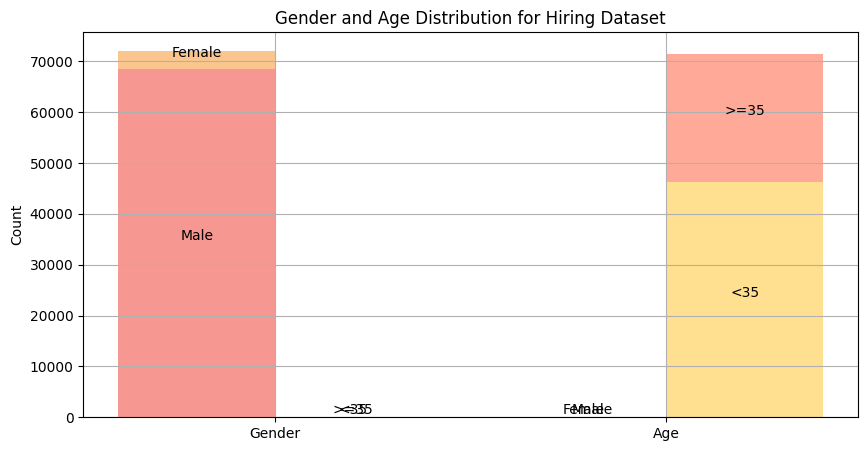

In [48]:
import matplotlib.pyplot as plt

# Assuming the following data
data = {
    'Gender': {'Male': 68573, 'Female': 3518},
    'Age': {'<35': 46293, '>=35': 25168}
}

labels = list(data.keys())
male = [data['Gender']['Male'], 0]
female = [data['Gender']['Female'], 0]
age_less_35 = [0, data['Age']['<35']]
age_more_eq_35 = [0, data['Age']['>=35']]

# Setting the positions and width for the bars
pos = list(range(len(male))) 
width = 0.4 

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with male data,
# in position pos,
bar1 = plt.bar(pos, male, width, alpha=0.5, color='#EE3224') 

# Create a bar with female data,
# in position pos,
bar2 = plt.bar(pos, female, width, bottom=male, alpha=0.5, color='#F78F1E')

# Create a bar with age_less_35 data,
# in position pos + some width buffer,
bar3 = plt.bar([p + width for p in pos], age_less_35, width, alpha=0.5, color='#FFC222') 

# Create a bar with age_more_eq_35 data,
# in position pos + some width buffer,
bar4 = plt.bar([p + width for p in pos], age_more_eq_35, width, bottom=age_less_35, alpha=0.5, color='#FF5733') 

# Writing the categories directly on the bars
for rect1, rect2, rect3, rect4 in zip(bar1, bar2, bar3, bar4):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    height3 = rect3.get_height()
    height4 = rect4.get_height()
    plt.text(rect1.get_x() + rect1.get_width()/2., height1/2., 'Male', ha='center', va='bottom')
    plt.text(rect2.get_x() + rect2.get_width()/2., height1 + height2/2., 'Female', ha='center', va='bottom')
    plt.text(rect3.get_x() + rect3.get_width()/2., height3/2., '<35', ha='center', va='bottom')
    plt.text(rect4.get_x() + rect4.get_width()/2., height3 + height4/2., '>=35', ha='center', va='bottom')

# Setting the y axis label
ax.set_ylabel('Count')

# Setting the chart's title
ax.set_title('Gender and Age Distribution for Hiring Dataset')

# Setting the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])

# Setting the labels for the x ticks
ax.set_xticklabels(labels)

plt.grid()
plt.show()

In [49]:
df_promo_train['age'].value_counts()

age
0    34183
1    20625
Name: count, dtype: int64

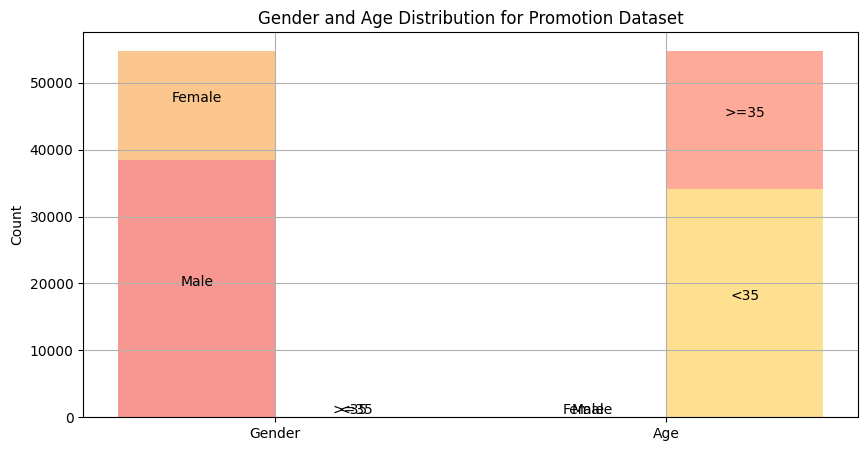

In [50]:
import matplotlib.pyplot as plt

# Assuming the following data
data = {
    'Gender': {'Male': 38496, 'Female': 16312},
    'Age': {'<35': 34183, '>=35': 20625}
}

labels = list(data.keys())
male = [data['Gender']['Male'], 0]
female = [data['Gender']['Female'], 0]
age_less_35 = [0, data['Age']['<35']]
age_more_eq_35 = [0, data['Age']['>=35']]

# Setting the positions and width for the bars
pos = list(range(len(male))) 
width = 0.4 

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with male data,
# in position pos,
bar1 = plt.bar(pos, male, width, alpha=0.5, color='#EE3224') 

# Create a bar with female data,
# in position pos,
bar2 = plt.bar(pos, female, width, bottom=male, alpha=0.5, color='#F78F1E')

# Create a bar with age_less_35 data,
# in position pos + some width buffer,
bar3 = plt.bar([p + width for p in pos], age_less_35, width, alpha=0.5, color='#FFC222') 

# Create a bar with age_more_eq_35 data,
# in position pos + some width buffer,
bar4 = plt.bar([p + width for p in pos], age_more_eq_35, width, bottom=age_less_35, alpha=0.5, color='#FF5733') 

# Writing the categories directly on the bars
for rect1, rect2, rect3, rect4 in zip(bar1, bar2, bar3, bar4):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    height3 = rect3.get_height()
    height4 = rect4.get_height()
    plt.text(rect1.get_x() + rect1.get_width()/2., height1/2., 'Male', ha='center', va='bottom')
    plt.text(rect2.get_x() + rect2.get_width()/2., height1 + height2/2., 'Female', ha='center', va='bottom')
    plt.text(rect3.get_x() + rect3.get_width()/2., height3/2., '<35', ha='center', va='bottom')
    plt.text(rect4.get_x() + rect4.get_width()/2., height3 + height4/2., '>=35', ha='center', va='bottom')

# Setting the y axis label
ax.set_ylabel('Count')

# Setting the chart's title
ax.set_title('Gender and Age Distribution for Promotion Dataset')

# Setting the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])

# Setting the labels for the x ticks
ax.set_xticklabels(labels)

plt.grid()
plt.show()